In [4]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time

import i3d
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13437151723394831920
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 131072
locality {
  bus_id: 1
}
incarnation: 18235339658750837477
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:02:00.0, compute capability: 6.1"
]


In [5]:
"""
Build RBG Graph
"""
_IMAGE_SIZE = 224
_NUM_CLASSES = 400

_SAMPLE_VIDEO_FRAMES = 79
_SAMPLE_PATHS = {
    'rgb': 'data/v_CricketShot_g04_c01_rgb.npy',
    'flow': 'data/v_CricketShot_g04_c01_flow.npy',
}

_CHECKPOINT_PATHS = {
    'rgb': 'data/checkpoints/rgb_scratch/model.ckpt',
    'flow': 'data/checkpoints/flow_scratch/model.ckpt',
    'rgb_imagenet': 'data/checkpoints/rgb_imagenet/model.ckpt',
    'flow_imagenet': 'data/checkpoints/flow_imagenet/model.ckpt',
}

_LABEL_MAP_PATH = 'data/label_map.txt'

#FLAGS = tf.flags.FLAGS

#tf.flags.DEFINE_string('eval_type', 'joint', 'rgb, flow, or joint')
#tf.flags.DEFINE_boolean('imagenet_pretrained', True, '')
tf.reset_default_graph()
tf.logging.set_verbosity(tf.logging.INFO)
#eval_type = FLAGS.eval_type
#imagenet_pretrained = FLAGS.imagenet_pretrained
kinetics_classes = [x.strip() for x in open(_LABEL_MAP_PATH)]
rgb_input = tf.placeholder(tf.float32, shape=(1, _SAMPLE_VIDEO_FRAMES, _IMAGE_SIZE, _IMAGE_SIZE, 3))
with tf.variable_scope('RGB'):
        rgb_model = i3d.InceptionI3d(_NUM_CLASSES, spatial_squeeze=True, final_endpoint='Logits')
        rgb_logits, _ = rgb_model(rgb_input, is_training=False, dropout_keep_prob=1.0)
rgb_variable_map = {}
for variable in tf.global_variables():
    if variable.name.split('/')[0] == 'RGB':
        rgb_variable_map[variable.name.replace(':0', '')] = variable
rgb_saver = tf.train.Saver(var_list=rgb_variable_map, reshape=True)
model_logits = rgb_logits
model_predictions = tf.nn.softmax(model_logits)

In [6]:
"""
Run sample prediction with RBG only
"""
eval_type = 'rgb'
imagenet_pretrained = True
print("wiener")

with tf.Session() as sess:
        feed_dict = {}
        if eval_type in ['rgb', 'joint']:
            if imagenet_pretrained:
                print("pretrained")
                rgb_saver.restore(sess, _CHECKPOINT_PATHS['rgb_imagenet'])
            else:
                rgb_saver.restore(sess, _CHECKPOINT_PATHS['rgb'])
            tf.logging.info('RGB checkpoint restored')
            rgb_sample = np.load(_SAMPLE_PATHS['rgb'])
            print("RGB size:", rgb_sample.shape)
            tf.logging.info('RGB data loaded, shape=%s', str(rgb_sample.shape))
            feed_dict[rgb_input] = rgb_sample

        if eval_type in ['flow', 'joint']:
            if imagenet_pretrained:
                flow_saver.restore(sess, _CHECKPOINT_PATHS['flow_imagenet'])
            else:
                flow_saver.restore(sess, _CHECKPOINT_PATHS['flow'])
            tf.logging.info('Flow checkpoint restored')
            flow_sample = np.load(_SAMPLE_PATHS['flow'])
            print("flow size:", flow_sample.shape)
            tf.logging.info('Flow data loaded, shape=%s',
                            str(flow_sample.shape))
            feed_dict[flow_input] = flow_sample
        out_logits, out_predictions = sess.run(
            [model_logits, model_predictions],
            feed_dict=feed_dict)
        out_logits = out_logits[0]
        out_predictions = out_predictions[0]
        sorted_indices = np.argsort(out_predictions)[::-1]

        print('Norm of logits: %f' % np.linalg.norm(out_logits))
        print('\nTop classes and probabilities')
        for index in sorted_indices[:20]:
            print(out_predictions[index], out_logits[
                  index], kinetics_classes[index])

wiener
pretrained
INFO:tensorflow:Restoring parameters from data/checkpoints/rgb_imagenet/model.ckpt
INFO:tensorflow:RGB checkpoint restored
RGB size: (1, 79, 224, 224, 3)
INFO:tensorflow:RGB data loaded, shape=(1, 79, 224, 224, 3)
Norm of logits: 87.108871

Top classes and probabilities
0.99999666 25.856651 playing cricket
1.3353437e-06 12.330333 playing kickball
4.553111e-07 11.25437 catching or throwing baseball
3.1434072e-07 10.883866 shooting goal (soccer)
1.9243265e-07 10.393135 catching or throwing softball
1.3096499e-07 10.008319 throwing discus
1.0681766e-07 9.804511 javelin throw
9.446424e-08 9.681611 golf putting
7.8428705e-08 9.495579 jogging
7.8017365e-08 9.49032 hitting baseball
6.608467e-08 9.324326 triple jump
3.487841e-08 8.685257 hurling (sport)
2.9965566e-08 8.533438 skateboarding
2.108369e-08 8.181889 hurdling
2.007925e-08 8.133077 playing tennis
1.8453855e-08 8.048662 breakdancing
1.7050759e-08 7.9695835 hammer throw
1.7004478e-08 7.9668655 shot put
1.46112935e-08 

In [11]:
print(sorted_indices)

[227 237  48 297  50 358 166 143 168 153 367 161 306 160 246  34 148 298
 182 150  94  51 156 142   3  45 256 173 151 192 174 209 349 357 175 245
 141  86 302 171  55 152 208  12  31 277 355 220 207 122  85 283 107  49
 346 288 120 314  92 280  43 235 307 261 105 325 363 251 136 179 157 218
  41 140 312 375 399 265 202   9 275 313 158  93 348 180 247 199 361 253
 273 374   5 232 170 318 330 329 257 309 244 154 316 342  87 274 164 240
 356 183 176  95  69 248 238  68  74 392  75 119  99  76 100 376 103 224
 345 236 262 254 127  20 128 200 382  26 260 267 281 279   1 226 377  67
 147 258 221 311 215   2 149 169   0 296 398 354 393  15 263 300 205 242
  30 259 269 378  59 343 339 118 289 373 340  60 337 109  84 177  16 255
  53  64 347 305  79 130 214 397 243 334  57 172 266 206 198 320 278 333
 106 231  40 114 319 219 326  96  44  39  54   4  88 287 101 115 303 383
 308 197 129 371 338 395 384 234 230  25 112 396 335 233 250  77 380  56
 264 304 203 162 223 310 389 165 134 186 276  10 21

In [15]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print(model_logits)
print(rgb_input)
with tf.device("/gpu:0"):
    with tf.Session() as sess:
        # THIS LINE NEEDS TO BE MOVED
        rgb_saver.restore(sess, _CHECKPOINT_PATHS['rgb_imagenet'])
        dX = tf.gradients(model_logits[0, sorted_indices[0]], rgb_input)
        print(dX)
        absolute = tf.abs(dX)
        print("why the 1?:", absolute.get_shape())
        maxes = tf.reduce_max(absolute, axis=5)
        squeezed = tf.squeeze(maxes)
        saliency = sess.run(squeezed, feed_dict={rgb_input:rgb_sample})
        #create_class_visualization(sess, 6, model_logits, rgb_input, num_iterations=1000)


Tensor("RGB/inception_i3d/Mean:0", shape=(1, 400), dtype=float32)
Tensor("Placeholder:0", shape=(1, 79, 224, 224, 3), dtype=float32)
INFO:tensorflow:Restoring parameters from data/checkpoints/rgb_imagenet/model.ckpt
[<tf.Tensor 'gradients_4/RGB/inception_i3d/Conv3d_1a_7x7/conv_3d/convolution_grad/Conv3DBackpropInputV2:0' shape=(1, 79, 224, 224, 3) dtype=float32>]
why the 1?: (1, 1, 79, 224, 224, 3)


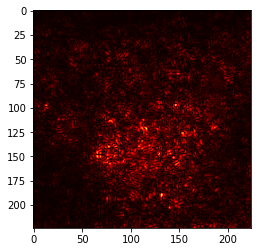

In [20]:
name = "cricket_saliency{}.png"
filenames = []
for i in range(79):
    plt.imshow(saliency[i], cmap=plt.cm.hot)
    # plt.show()
    filename = name.format(i)
    filenames.append(filename)
    plt.savefig(name.format(i))

import imageio
images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('./cricket_saliency.gif', images)

In [23]:
from IPython.display import HTML
HTML('<img src>="./cricket_saliency.gif"')
#Image(filename='./cricket_saliency.gif')
